# 1. Install Dependencies and Setup
Install the required libraries to run the project. We use TensorFlow for the model, OpenCV for image processing, and Matplotlib for visualization.

In [1]:
!pip install tensorflow opencv-python matplotlib

In [2]:
import os
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# 2. Load Data
We load the augmented images and labels created in the DataCollection steps.

### 2.1 Load Images

In [4]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [5]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250)))
train_images = train_images.map(lambda x: x/255)

In [6]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
test_images = test_images.map(lambda x: x/255)

In [7]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
val_images = val_images.map(lambda x: x/255)

### 2.2 Prepare Labels

In [8]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['keypoints']]

In [9]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [10]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [11]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

### 2.3. Combine Labels and Images

In [12]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(16)
train = train.prefetch(4)

In [13]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(16)
test = test.prefetch(4)

In [14]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(16)
val = val.prefetch(4)

### 2.4 View Samples

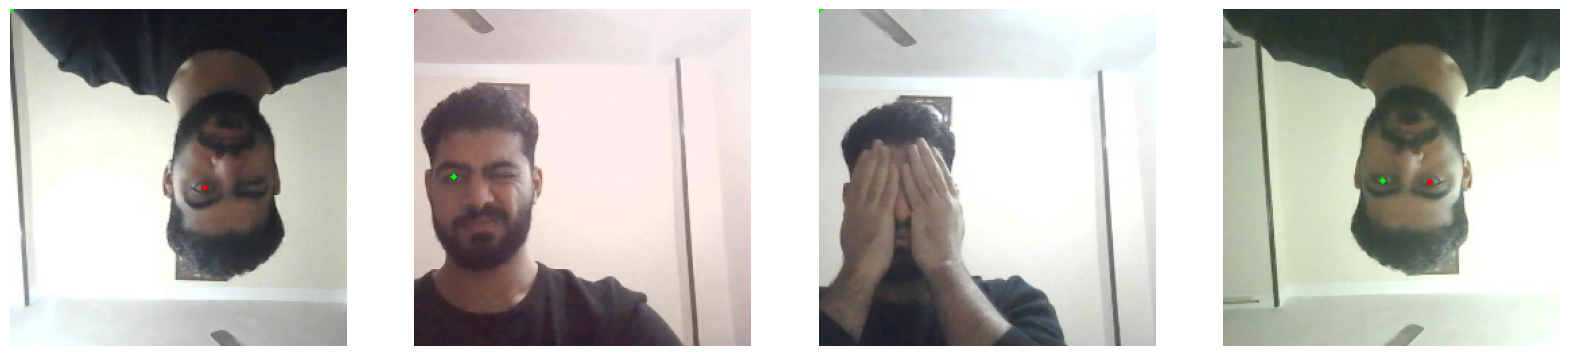

In [22]:
try:
    data_samples = train.as_numpy_iterator()
    res = data_samples.next()
    fig, ax = plt.subplots(ncols=4, figsize=(20,20))
    for idx in range(4): 
        sample_image = res[0][idx]               # float32 in [0,1]
        sample_coords = res[1][0][idx]           # labels wrapped in a tuple
        
        # Make a writable uint8 copy for OpenCV drawing, then convert back for matplotlib
        img_uint8 = (sample_image * 255).astype('uint8').copy()
        
        cv2.circle(img_uint8, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
        cv2.circle(img_uint8, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
        
        ax[idx].imshow(img_uint8/255.0)
        ax[idx].axis('off')
    plt.show()
except Exception as e:
    print("Could not visualize samples, possibly due to empty dataset.")
    print(e)

# 3. Build Model
We use a ResNet50V2 architecture which ensures high accuracy while being more efficient than heavier models like ResNet152.

### 3.1 Create Neural Network

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import ResNet50V2

In [17]:
# Updated to ResNet50V2 for better efficiency
model = Sequential([
    Input(shape=(250,250,3)), 
    ResNet50V2(include_top=False, input_shape=(250,250,3)),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(256, 3, 2, padding='same', activation='relu'),
    Conv2D(256, 2, 2, activation='relu'),
    Dropout(0.05),
    Conv2D(4, 2, 2),
    Reshape((4,))
])

model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 48s 1us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 8, 8, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 8, 8, 512)      │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 256)      │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 1, 4)        │         4,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,808,708 (140.41 MB)

 Trainable params: 36,763,268 (140.24 MB)

 Non-trainable params: 45,440 (177.50 KB)

### 3.2 Setup Losses and Optimizer

In [18]:
# Use efficient Adam optimizer with a learning rate decay schedule if possible, but static for now
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.MeanSquaredError()

In [19]:
model.compile(optimizer, loss)

### 3.3 Sense Check predictions

In [20]:
try:
    X, y = train.as_numpy_iterator().next()
    scores = model.predict(X)
    print(scores)
except Exception as e:
    print("Could not run sense check, check data availability.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[ 0.39954302  1.2960657   2.0395434   0.5712129 ]
 [-0.00370656  0.6501275   1.2271581   0.1540164 ]
 [ 0.26101792  1.0655643   0.4044895   0.12374191]
 [ 1.0815727   0.9707136   1.5747311   0.77322173]
 [-0.2274628   0.5763243   1.3765651   0.9589335 ]
 [-0.06638592  0.85030466  0.66618073  0.5790292 ]
 [ 0.49028018  0.97614175  1.6870828   0.2202568 ]
 [-0.4689839   0.6838804   1.3309863   0.5732398 ]
 [-0.15470907  0.18158792  0.95368326  0.70271057]
 [ 0.13197167  0.47616252  1.3877256   0.06769036]
 [ 0.19256493  0.69161516  1.0807862   0.3833311 ]
 [ 0.13765442  1.5366809   0.78501344  0.8457554 ]
 [-0.06448312  0.6118561   1.5159734   0.36080495]
 [ 0.30486307  0.68263805  1.8207129   0.11830862]
 [ 0.03692272  0.59625834  0.98064446  0.47613022]
 [ 0.47234488  0.8953096   0.62438923  0.66324264]]


### 3.4 Train the Model
We use EarlyStopping and ModelCheckpoint to save the best model and avoid overfitting.

In [32]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(13440, 13440, 2880, 2880, 2880, 2880)

In [33]:
train.as_numpy_iterator().next()[1]

array([[[[[[0.    ]]],


         [[[0.    ]]],


         [[[0.3792]]],


         [[[0.4756]]]],



        [[[[0.326 ]]],


         [[[0.504 ]]],


         [[[0.    ]]],


         [[[0.    ]]]],



        [[[[0.3958]]],


         [[[0.488 ]]],


         [[[0.2607]]],


         [[[0.4927]]]],



        [[[[0.39  ]]],


         [[[0.5107]]],


         [[[0.    ]]],


         [[[0.    ]]]],



        [[[[0.67  ]]],


         [[[0.5396]]],


         [[[0.    ]]],


         [[[0.    ]]]],



        [[[[0.4553]]],


         [[[0.5034]]],


         [[[0.5933]]],


         [[[0.5083]]]],



        [[[[0.342 ]]],


         [[[0.4966]]],


         [[[0.477 ]]],


         [[[0.4917]]]],



        [[[[0.3745]]],


         [[[0.522 ]]],


         [[[0.    ]]],


         [[[0.    ]]]],



        [[[[0.    ]]],


         [[[0.    ]]],


         [[[0.5073]]],


         [[[0.481 ]]]],



        [[[[0.3376]]],


         [[[0.487 ]]],


         [[[0.4758]]],


       

In [25]:
x, y = next(iter(train))
print(type(x), type(y))
print(x.shape)
# y may be wrapped in a tuple/list (from tf.py_function). Unwrap safely.
y_unwrapped = y[0] if isinstance(y, (tuple, list)) else y
print(y_unwrapped.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tuple'>
(16, 250, 250, 3)
(16, 4)


In [38]:
for x, y in train.take(1):
    # x is a batch of images, y may contain extra singleton dims from tf.py_function
    print(x.shape)
    print(type(y))

    # remove any singleton dimensions to get (batch_size, 4)
    y_squeezed = tf.squeeze(y)
    print(y_squeezed.shape)

    # now it's safe to index into the batch
    print(y_squeezed[0].shape, y_squeezed[1].shape)

(16, 250, 250, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(16, 4)
(4,) (4,)


In [39]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# =========================
# 1. FIX LABEL SHAPE
# =========================
def fix_label_shape(x, y):
    # Ensure labels are always (batch_size, 4)
    y = tf.reshape(y, (-1, 4))
    y.set_shape([None, 4])  # critical: static shape for Keras
    return x, y

# Apply shape fix to datasets
train = train.map(
    fix_label_shape,
    num_parallel_calls=tf.data.AUTOTUNE
)

val = val.map(
    fix_label_shape,
    num_parallel_calls=tf.data.AUTOTUNE
)

# Optional but recommended
train = train.prefetch(tf.data.AUTOTUNE)
val   = val.prefetch(tf.data.AUTOTUNE)

# =========================
# 2. COMPILE MODEL
# =========================
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# =========================
# 3. CALLBACKS
# =========================
checkpoint = ModelCheckpoint(
    'eyetrackerresnet.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# =========================
# 4. TRAIN MODEL
# =========================
history = model.fit(
    train,
    validation_data=val,
    epochs=20,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/20
840/840 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - loss: 0.8042 - mae: 0.2158 
Epoch 1: val_loss improved from None to 0.01306, saving model to eyetrackerresnet.h5


840/840 ━━━━━━━━━━━━━━━━━━━━ 15882s 19s/step - loss: 0.1437 - mae: 0.1148 - val_loss: 0.0131 - val_mae: 0.0670
Epoch 2/20
840/840 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0044 - mae: 0.0405
Epoch 2: val_loss did not improve from 0.01306
840/840 ━━━━━━━━━━━━━━━━━━━━ 2667s 3s/step - loss: 0.0037 - mae: 0.0367 - val_loss: 0.0726 - val_mae: 0.2029
Epoch 3/20
840/840 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - loss: 0.0039 - mae: 0.0363 
Epoch 3: val_loss did not improve from 0.01306
840/840 ━━━━━━━━━━━━━━━━━━━━ 10297s 12s/step - loss: 0.0041 - mae: 0.0359 - val_loss: 0.0157 - val_mae: 0.0739
Epoch 4/20
840/840 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0032 - mae: 0.0315
Epoch 4: val_loss did not improve from 0.01306
840/840 ━━━━━━━━━━━━━━━━━━━━ 3136s 4s/step - loss: 0.0045 - mae: 0.0355 - val_loss: 0.0165 - val_mae: 0.0630
Epoch 5/20
840/840 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.0036 - mae: 0.0308
Epoch 5: val_loss did not improve from 0.01306
840/840 ━━━━━━━━━━━━━━━━━━━━ 7370s 9s/step - loss:

In [40]:
for x, y in train.take(1):
    print(x.shape)  # (batch, H, W, C)
    print(y.shape)  # (batch, 4)

(16, 250, 250, 3)
(16, 4)


# 4. Review Performance

### 4.1 View Loss Plots

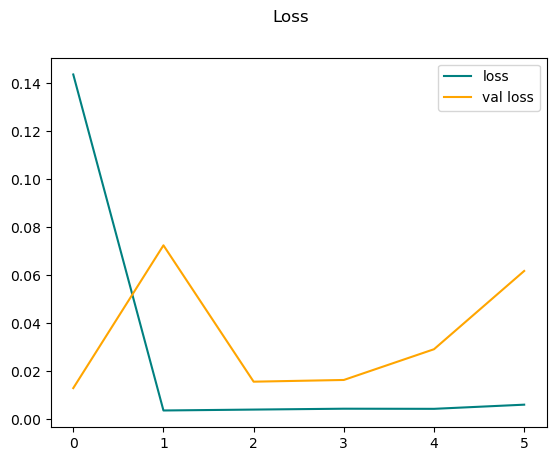

In [42]:
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

### 4.2. Make Predictions on Test

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Error in prediction visualization: OpenCV(4.12.0) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - img marked as output argument, but provided NumPy array marked as readonly
>  - Expected Ptr<cv::UMat> for argument 'img'



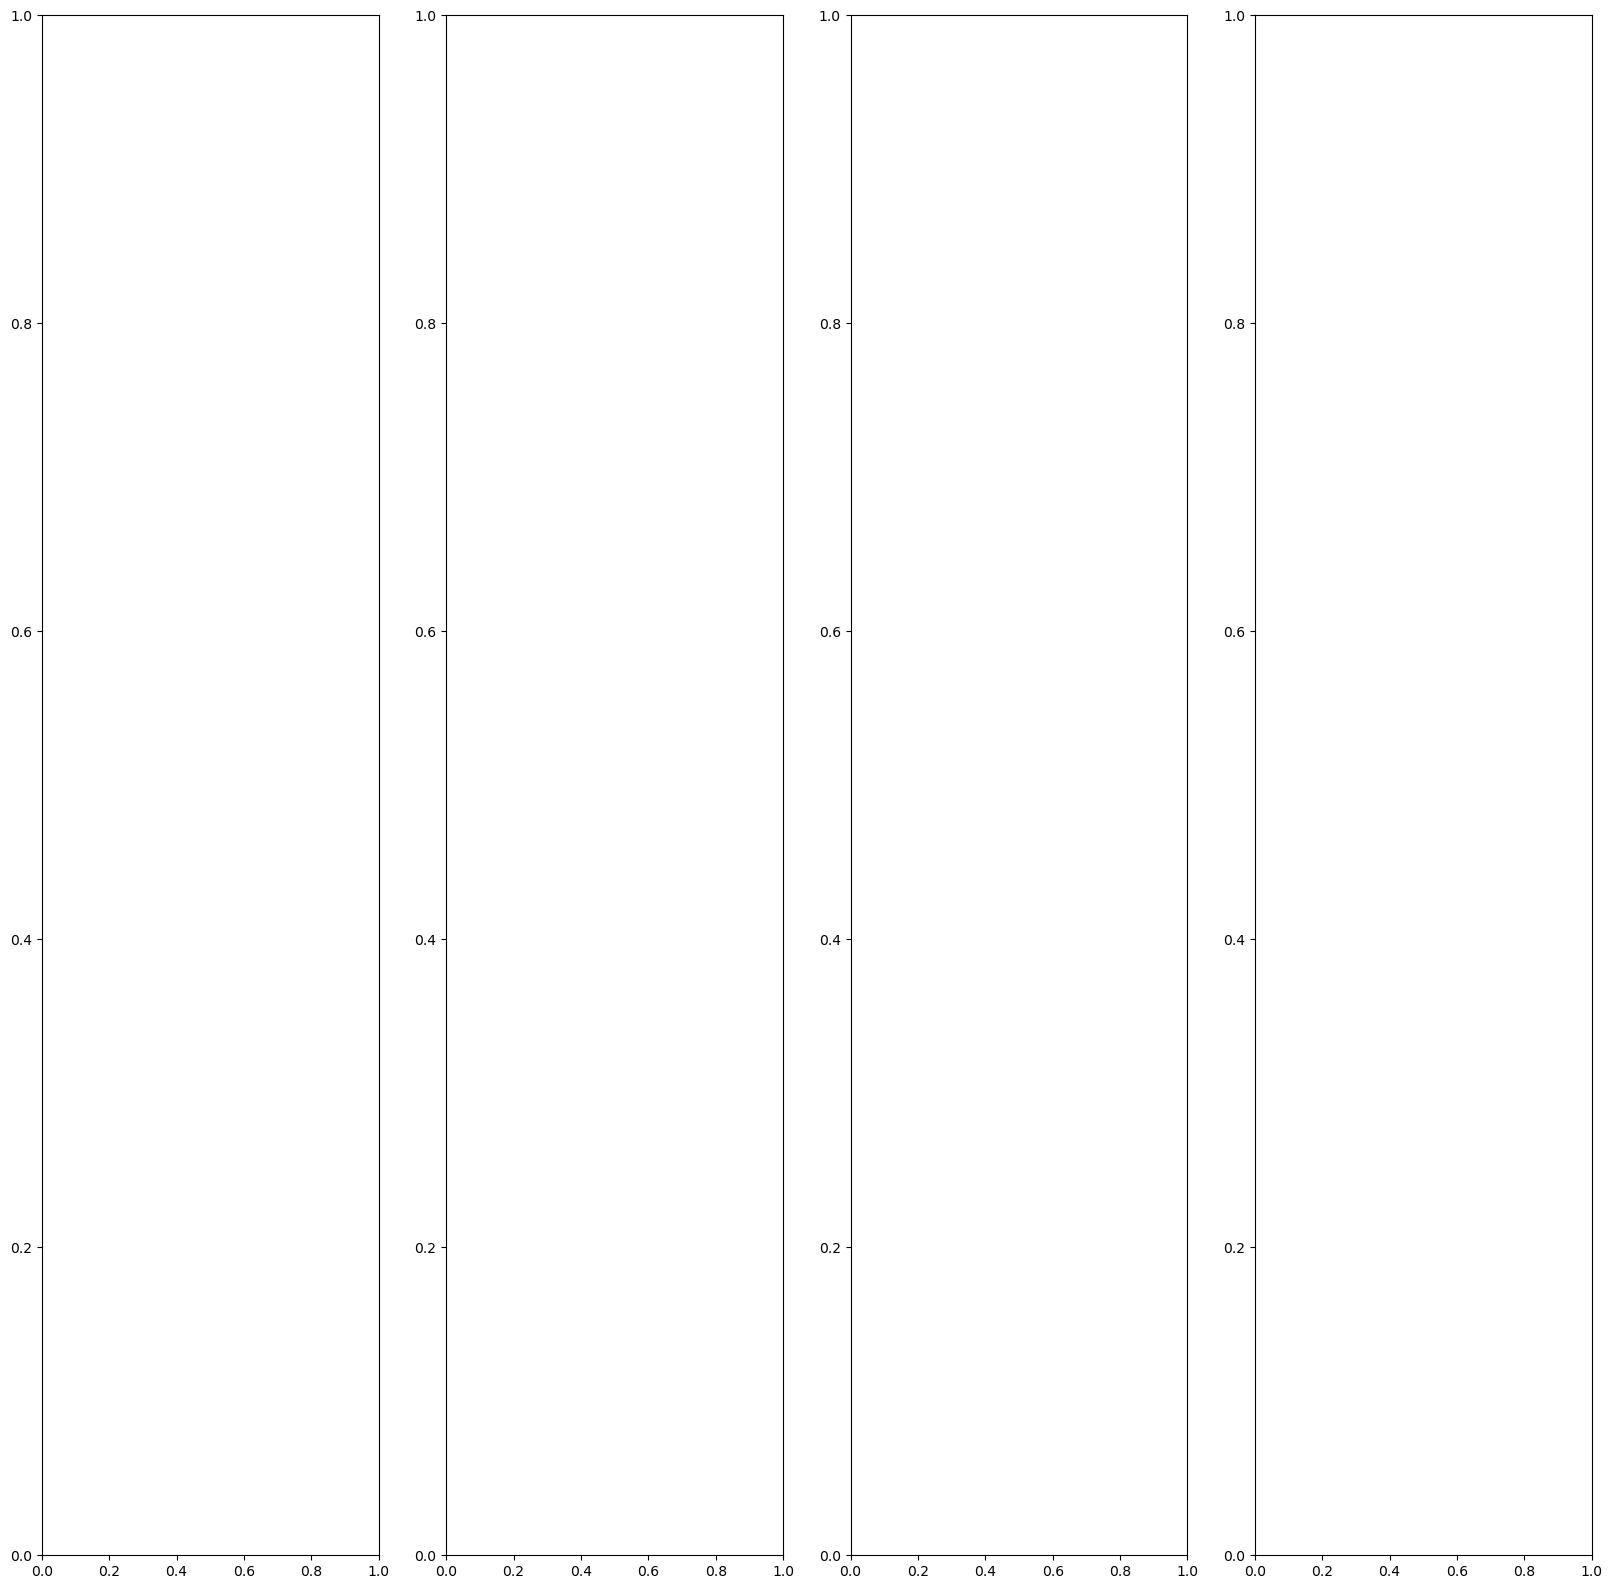

In [43]:
try:
    test_data = test.as_numpy_iterator()
    test_sample = test_data.next()
    yhat = model.predict(test_sample[0])
    
    fig, ax = plt.subplots(ncols=4, figsize=(20,20))
    for idx in range(4): 
        sample_image = test_sample[0][idx]
        sample_coords = yhat[idx]
        
        cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
        cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
        
        ax[idx].imshow(sample_image)
    plt.show()
except Exception as e:
    print("Error in prediction visualization:", e)

### 4.3. Save the Model

In [44]:
from tensorflow.keras.models import load_model
model.save('eyetrackerresnet.h5')

# 5. Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    
    # Verify frame capture
    if frame is None:
        break
        
    # Dynamic cropping to center of the frame (optional, ensuring we don't go out of bounds)
    h, w, _ = frame.shape
    # We want a 450x450 crop or similar. Let's start with the original hardcrop but make it safer
    # frame = frame[50:500,50:500,:] 
    # Safer crop:
    start_y, start_x = 50, 50
    end_y, end_x = 500, 500
    
    if h < 500 or w < 500:
        # If image is too small, resize it first or just use center crop
        pass # For now, assuming standard webcam 640x480

    cropped_frame = frame[start_y:end_y, start_x:end_x, :]
    if cropped_frame.size == 0:
        # Fallback if crop is invalid
        cropped_frame = frame

    rgb_img = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb_img, (250,250))
    
    yhat = model.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[0,:4]
    
    cv2.circle(cropped_frame, tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(cropped_frame, tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 2, (0,255,0), -1)
    
    cv2.imshow('EyeTrack', cropped_frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()